# Multi-Layer Perceptron from First Principles
## From Single Perceptron to Deep Neural Networks

---

### Table of Contents
1. [Setup & Imports](#setup)
2. [Part 1: The Perceptron](#perceptron)
   - Single Neuron with Activation
   - Sigmoid Function
   - Binary Cross-Entropy Loss
   - Gradient Derivation
3. [Part 2: Multi-Layer Perceptron Theory](#mlp-theory)
   - Architecture Overview
   - Forward Propagation
   - Backpropagation Derivation
   - Chain Rule Through Layers
4. [Part 3: Implementation](#implementation)
   - Activation Functions
   - Layer Class
   - MLP Class
5. [Part 4: Experiments](#experiments)
   - Binary Classification (Perceptron)
   - XOR Problem (Why We Need MLPs)
   - Non-Linear Classification
6. [Part 5: Visualization](#visualization)
7. [Summary](#summary)

---

<a id='setup'></a>
## 1. Setup & Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

<a id='perceptron'></a>
## 2. Part 1: The Perceptron

---

### Single Neuron with Activation Function

The perceptron extends linear regression by adding a **non-linear activation function**:

$$z = w^\top x + b$$
$$a = \sigma(z)$$

where $\sigma$ is the activation function (e.g., sigmoid).

### The Sigmoid Function

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

**Properties:**
- Range: $(0, 1)$ - perfect for binary classification
- Smooth and differentiable everywhere
- $\sigma(0) = 0.5$

**Derivative:**
$$\frac{d\sigma}{dz} = \sigma(z)(1 - \sigma(z))$$

**Proof of derivative:**

Let $\sigma(z) = \frac{1}{1 + e^{-z}} = (1 + e^{-z})^{-1}$

Using chain rule:
$$\frac{d\sigma}{dz} = -(1 + e^{-z})^{-2} \cdot \frac{d}{dz}(1 + e^{-z})$$

$$= -(1 + e^{-z})^{-2} \cdot (-e^{-z})$$

$$= \frac{e^{-z}}{(1 + e^{-z})^2}$$

Now, notice:
$$\sigma(z)(1 - \sigma(z)) = \frac{1}{1+e^{-z}} \cdot \frac{e^{-z}}{1+e^{-z}} = \frac{e^{-z}}{(1+e^{-z})^2}$$

Therefore: $\boxed{\sigma'(z) = \sigma(z)(1-\sigma(z))}$

This is computationally efficient since we already computed $\sigma(z)$ in the forward pass!

### Binary Cross-Entropy Loss

For binary classification with true label $y \in \{0, 1\}$ and prediction $\hat{y} = \sigma(z)$:

$$L = -\frac{1}{n}\sum_{i=1}^n \Big[y_i \log(\hat{y}_i) + (1-y_i)\log(1-\hat{y}_i)\Big]$$

**Why this loss?**
- Derived from maximum likelihood estimation
- Penalizes confident wrong predictions heavily
- Convex for logistic regression (single layer)

### Gradient of Binary Cross-Entropy w.r.t. Output

For one sample:
$$\ell = -[y \log(\hat{y}) + (1-y)\log(1-\hat{y})]$$

where $\hat{y} = \sigma(z)$.

$$\frac{\partial \ell}{\partial \hat{y}} = -\frac{y}{\hat{y}} + \frac{1-y}{1-\hat{y}}$$

**Combine with activation gradient using chain rule:**

$$\frac{\partial \ell}{\partial z} = \frac{\partial \ell}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial z}$$

$$= \Big(-\frac{y}{\hat{y}} + \frac{1-y}{1-\hat{y}}\Big) \cdot \hat{y}(1-\hat{y})$$

$$= -y(1-\hat{y}) + (1-y)\hat{y}$$

$$= -y + y\hat{y} + \hat{y} - y\hat{y}$$

$$= \boxed{\hat{y} - y}$$

**Beautiful result!** The gradient is simply the prediction error, just like MSE!

### Gradient w.r.t. Weights and Bias

Since $z = w^\top x + b$:

$$\frac{\partial z}{\partial w} = x, \quad \frac{\partial z}{\partial b} = 1$$

By chain rule:

$$\frac{\partial \ell}{\partial w} = \frac{\partial \ell}{\partial z} \cdot \frac{\partial z}{\partial w} = (\hat{y} - y) x$$

$$\frac{\partial \ell}{\partial b} = \frac{\partial \ell}{\partial z} \cdot \frac{\partial z}{\partial b} = (\hat{y} - y)$$

**Averaged over batch:**

$$\nabla_w L = \frac{1}{n}\sum_{i=1}^n (\hat{y}_i - y_i)x_i = \frac{1}{n}X^\top(\hat{y} - y)$$

$$\frac{\partial L}{\partial b} = \frac{1}{n}\sum_{i=1}^n (\hat{y}_i - y_i)$$

<a id='mlp-theory'></a>
## 3. Part 2: Multi-Layer Perceptron Theory

---

### Why Do We Need Multiple Layers?

**The XOR Problem:**

| $x_1$ | $x_2$ | XOR |
|-------|-------|-----|
| 0     | 0     | 0   |
| 0     | 1     | 1   |
| 1     | 0     | 1   |
| 1     | 1     | 0   |

A single perceptron (linear classifier) **cannot** solve XOR - it's not linearly separable!

**Solution:** Stack multiple layers to learn non-linear decision boundaries.

### MLP Architecture

Consider a 2-layer network (1 hidden layer):

**Input:** $x \in \mathbb{R}^{d}$

**Hidden layer:**
$$z^{[1]} = W^{[1]}x + b^{[1]}, \quad W^{[1]} \in \mathbb{R}^{h \times d}$$
$$a^{[1]} = \sigma(z^{[1]}), \quad a^{[1]} \in \mathbb{R}^{h}$$

**Output layer:**
$$z^{[2]} = W^{[2]}a^{[1]} + b^{[2]}, \quad W^{[2]} \in \mathbb{R}^{o \times h}$$
$$\hat{y} = a^{[2]} = \sigma(z^{[2]}), \quad \hat{y} \in \mathbb{R}^{o}$$

where:
- $d$ = input dimension
- $h$ = hidden layer size
- $o$ = output dimension (1 for binary classification)
- $\sigma$ = activation function (sigmoid, ReLU, tanh, etc.)

### Forward Propagation (Detailed)

**Step-by-step for one sample:**

1. **Input:** $x \in \mathbb{R}^{d}$

2. **Hidden layer computation:**
   $$z^{[1]}_j = \sum_{k=1}^{d} W^{[1]}_{jk} x_k + b^{[1]}_j, \quad j=1,\ldots,h$$
   $$a^{[1]}_j = \sigma(z^{[1]}_j)$$

3. **Output layer computation:**
   $$z^{[2]}_i = \sum_{j=1}^{h} W^{[2]}_{ij} a^{[1]}_j + b^{[2]}_i, \quad i=1,\ldots,o$$
   $$\hat{y}_i = \sigma(z^{[2]}_i)$$

4. **Loss:**
   $$L = -\frac{1}{n}\sum \Big[y \log(\hat{y}) + (1-y)\log(1-\hat{y})\Big]$$

**Vectorized form:**
```
z[1] = W[1] @ x + b[1]
a[1] = sigma(z[1])
z[2] = W[2] @ a[1] + b[2]
y_hat = sigma(z[2])
```

### Backpropagation: The Chain Rule

**Goal:** Compute $\frac{\partial L}{\partial W^{[1]}}, \frac{\partial L}{\partial b^{[1]}}, \frac{\partial L}{\partial W^{[2]}}, \frac{\partial L}{\partial b^{[2]}}$

**Key idea:** Work backwards from loss, applying chain rule at each step.

---

### Step 1: Output Layer Gradients

**Loss gradient w.r.t. output activation:**
$$\delta^{[2]} = \frac{\partial L}{\partial z^{[2]}} = \hat{y} - y$$

(We proved this earlier for sigmoid + binary cross-entropy)

**Gradients for output layer parameters:**

$$\frac{\partial L}{\partial W^{[2]}} = \delta^{[2]} \otimes a^{[1]} = \delta^{[2]} (a^{[1]})^\top$$

**Why?** Because $z^{[2]}_i = \sum_j W^{[2]}_{ij} a^{[1]}_j + b^{[2]}_i$

So: $\frac{\partial z^{[2]}_i}{\partial W^{[2]}_{ij}} = a^{[1]}_j$

By chain rule: $\frac{\partial L}{\partial W^{[2]}_{ij}} = \frac{\partial L}{\partial z^{[2]}_i} \cdot a^{[1]}_j = \delta^{[2]}_i \cdot a^{[1]}_j$

**Bias gradient:**
$$\frac{\partial L}{\partial b^{[2]}} = \delta^{[2]}$$

(Since $\frac{\partial z^{[2]}}{\partial b^{[2]}} = 1$)

### Step 2: Hidden Layer Gradients

**Gradient w.r.t. hidden activation:**

By chain rule through the next layer:
$$\frac{\partial L}{\partial a^{[1]}} = (W^{[2]})^\top \delta^{[2]}$$

**Why?** Because $z^{[2]} = W^{[2]} a^{[1]} + b^{[2]}$

So: $\frac{\partial z^{[2]}}{\partial a^{[1]}} = W^{[2]}$

And: $\frac{\partial L}{\partial a^{[1]}} = \frac{\partial L}{\partial z^{[2]}} \cdot \frac{\partial z^{[2]}}{\partial a^{[1]}} = \delta^{[2]} \cdot W^{[2]} = (W^{[2]})^\top \delta^{[2]}$

**Gradient w.r.t. hidden pre-activation:**

$$\delta^{[1]} = \frac{\partial L}{\partial z^{[1]}} = \frac{\partial L}{\partial a^{[1]}} \odot \sigma'(z^{[1]})$$

where $\odot$ is element-wise multiplication (Hadamard product).

For sigmoid: $\sigma'(z^{[1]}) = a^{[1]} \odot (1 - a^{[1]})$

So: $\delta^{[1]} = [(W^{[2]})^\top \delta^{[2]}] \odot a^{[1]} \odot (1-a^{[1]})$

**Gradients for hidden layer parameters:**

$$\frac{\partial L}{\partial W^{[1]}} = \delta^{[1]} \otimes x = \delta^{[1]} x^\top$$

$$\frac{\partial L}{\partial b^{[1]}} = \delta^{[1]}$$

### Backpropagation Algorithm Summary

**Forward Pass:**
1. $z^{[1]} = W^{[1]}x + b^{[1]}$
2. $a^{[1]} = \sigma(z^{[1]})$
3. $z^{[2]} = W^{[2]}a^{[1]} + b^{[2]}$
4. $\hat{y} = \sigma(z^{[2]})$
5. $L = -[y \log(\hat{y}) + (1-y)\log(1-\hat{y})]$

**Backward Pass:**
1. $\delta^{[2]} = \hat{y} - y$
2. $\frac{\partial L}{\partial W^{[2]}} = \delta^{[2]} (a^{[1]})^\top$, $\frac{\partial L}{\partial b^{[2]}} = \delta^{[2]}$
3. $\delta^{[1]} = [(W^{[2]})^\top \delta^{[2]}] \odot \sigma'(z^{[1]})$
4. $\frac{\partial L}{\partial W^{[1]}} = \delta^{[1]} x^\top$, $\frac{\partial L}{\partial b^{[1]}} = \delta^{[1]}$

**Parameter Update:**
$$W^{[\ell]} \leftarrow W^{[\ell]} - \eta \frac{\partial L}{\partial W^{[\ell]}}$$
$$b^{[\ell]} \leftarrow b^{[\ell]} - \eta \frac{\partial L}{\partial b^{[\ell]}}$$

where $\eta$ is the learning rate.

### Key Insight: The "Error Signal" Flows Backward

- $\delta^{[2]}$ is the error at the output
- $\delta^{[1]}$ is the error "backpropagated" through $W^{[2]}$ and scaled by $\sigma'$
- Each layer receives an error signal from the next layer
- This generalizes to arbitrary depth!

**For $L$ layers:** $\delta^{[\ell]} = [(W^{[\ell+1]})^\top \delta^{[\ell+1]}] \odot \sigma'(z^{[\ell]})$

<a id='implementation'></a>
## 4. Part 3: Implementation

---

### Activation Functions

In [2]:
def sigmoid(z):
    """Sigmoid activation function."""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def sigmoid_derivative(a):
    """Derivative of sigmoid given activation a = sigmoid(z)."""
    return a * (1 - a)

def relu(z):
    """ReLU activation function."""
    return np.maximum(0, z)

def relu_derivative(z):
    """Derivative of ReLU."""
    return (z > 0).astype(float)

def tanh(z):
    """Tanh activation function."""
    return np.tanh(z)

def tanh_derivative(a):
    """Derivative of tanh given activation a = tanh(z)."""
    return 1 - a**2

### Binary Cross-Entropy Loss

In [3]:
def binary_cross_entropy(y_true, y_pred):
    """
    Binary cross-entropy loss.
    
    Args:
        y_true: True labels (n_samples,)
        y_pred: Predicted probabilities (n_samples,)
    
    Returns:
        Scalar loss value
    """
    epsilon = 1e-15  # Avoid log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

### Layer Class

In [4]:
class Layer:
    """A single fully-connected layer."""
    
    def __init__(self, input_size, output_size, activation='sigmoid'):
        """
        Initialize layer parameters.
        
        Args:
            input_size: Number of input features
            output_size: Number of neurons in this layer
            activation: 'sigmoid', 'relu', or 'tanh'
        """
        # Xavier/Glorot initialization
        limit = np.sqrt(6 / (input_size + output_size))
        self.W = np.random.uniform(-limit, limit, (output_size, input_size))
        self.b = np.zeros((output_size, 1))
        
        # Activation function
        self.activation = activation
        if activation == 'sigmoid':
            self.activate = sigmoid
            self.activate_derivative = sigmoid_derivative
        elif activation == 'relu':
            self.activate = relu
            self.activate_derivative = relu_derivative
        elif activation == 'tanh':
            self.activate = tanh
            self.activate_derivative = tanh_derivative
        
        # Cache for backprop
        self.z = None
        self.a = None
        self.x = None
    
    def forward(self, x):
        """
        Forward pass through the layer.
        
        Args:
            x: Input of shape (input_size, batch_size)
        
        Returns:
            Activation of shape (output_size, batch_size)
        """
        self.x = x
        self.z = self.W @ x + self.b
        self.a = self.activate(self.z)
        return self.a
    
    def backward(self, delta_next):
        """
        Backward pass through the layer.
        
        Args:
            delta_next: Gradient from next layer (output_size, batch_size)
        
        Returns:
            delta: Gradient to pass to previous layer (input_size, batch_size)
            dW: Weight gradient (output_size, input_size)
            db: Bias gradient (output_size, 1)
        """
        batch_size = self.x.shape[1]
        
        # Gradient w.r.t. pre-activation
        if self.activation == 'sigmoid' or self.activation == 'tanh':
            delta = delta_next * self.activate_derivative(self.a)
        else:  # ReLU
            delta = delta_next * self.activate_derivative(self.z)
        
        # Gradients for parameters
        dW = delta @ self.x.T / batch_size
        db = np.sum(delta, axis=1, keepdims=True) / batch_size
        
        # Gradient to pass to previous layer
        delta_prev = self.W.T @ delta
        
        return delta_prev, dW, db

### Multi-Layer Perceptron Class

In [5]:
class MLP:
    """Multi-Layer Perceptron for binary classification."""
    
    def __init__(self, layer_sizes, activations=None):
        """
        Initialize MLP.
        
        Args:
            layer_sizes: List of layer sizes [input_size, hidden1, hidden2, ..., output_size]
            activations: List of activation functions for each layer (default: all sigmoid)
        """
        self.layers = []
        
        if activations is None:
            activations = ['sigmoid'] * (len(layer_sizes) - 1)
        
        for i in range(len(layer_sizes) - 1):
            layer = Layer(layer_sizes[i], layer_sizes[i+1], activations[i])
            self.layers.append(layer)
        
        self.losses = []
    
    def forward(self, X):
        """
        Forward pass through all layers.
        
        Args:
            X: Input of shape (input_size, batch_size)
        
        Returns:
            Output of shape (output_size, batch_size)
        """
        a = X
        for layer in self.layers:
            a = layer.forward(a)
        return a
    
    def backward(self, y_true, y_pred):
        """
        Backward pass through all layers.
        
        Args:
            y_true: True labels (output_size, batch_size)
            y_pred: Predicted values (output_size, batch_size)
        
        Returns:
            List of (dW, db) tuples for each layer
        """
        # Initial gradient (for binary cross-entropy + sigmoid)
        delta = y_pred - y_true
        
        gradients = []
        
        # Backpropagate through layers in reverse
        for i in range(len(self.layers) - 1, -1, -1):
            if i == len(self.layers) - 1:
                # Output layer: delta already computed
                batch_size = self.layers[i].x.shape[1]
                dW = delta @ self.layers[i].x.T / batch_size
                db = np.sum(delta, axis=1, keepdims=True) / batch_size
                delta_prev = self.layers[i].W.T @ delta
            else:
                # Hidden layers
                delta_prev, dW, db = self.layers[i].backward(delta)
            
            gradients.insert(0, (dW, db))
            delta = delta_prev
        
        return gradients
    
    def update_parameters(self, gradients, learning_rate):
        """Update all layer parameters."""
        for layer, (dW, db) in zip(self.layers, gradients):
            layer.W -= learning_rate * dW
            layer.b -= learning_rate * db
    
    def fit(self, X, y, learning_rate=0.1, epochs=1000, verbose=True):
        """
        Train the MLP.
        
        Args:
            X: Training data of shape (n_samples, n_features)
            y: Labels of shape (n_samples,)
            learning_rate: Learning rate
            epochs: Number of training epochs
            verbose: Whether to print progress
        """
        # Transpose to (features, samples)
        X_T = X.T
        y_T = y.reshape(1, -1)
        
        self.losses = []
        
        for epoch in range(epochs):
            # Forward pass
            y_pred = self.forward(X_T)
            
            # Compute loss
            loss = binary_cross_entropy(y_T.flatten(), y_pred.flatten())
            self.losses.append(loss)
            
            # Backward pass
            gradients = self.backward(y_T, y_pred)
            
            # Update parameters
            self.update_parameters(gradients, learning_rate)
            
            # Print progress
            if verbose and (epoch + 1) % 200 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.6f}")
        
        if verbose:
            print(f"\nTraining completed. Final loss: {self.losses[-1]:.6f}")
    
    def predict_proba(self, X):
        """Predict probabilities."""
        X_T = X.T
        return self.forward(X_T).T
    
    def predict(self, X, threshold=0.5):
        """Predict class labels."""
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int).flatten()
    
    def score(self, X, y):
        """Compute accuracy."""
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

<a id='experiments'></a>
## 5. Part 4: Experiments

---

### Experiment 1: Binary Classification with Perceptron

Let's start with a simple linearly separable problem.

In [6]:
# Set random seed
np.random.seed(42)

# Generate linearly separable data
n_samples = 200

# Class 0: centered at (-2, -2)
X_class0 = np.random.randn(n_samples // 2, 2) + np.array([-2, -2])
y_class0 = np.zeros(n_samples // 2)

# Class 1: centered at (2, 2)
X_class1 = np.random.randn(n_samples // 2, 2) + np.array([2, 2])
y_class1 = np.ones(n_samples // 2)

# Combine
X_linear = np.vstack([X_class0, X_class1])
y_linear = np.concatenate([y_class0, y_class1])

# Shuffle
shuffle_idx = np.random.permutation(n_samples)
X_linear = X_linear[shuffle_idx]
y_linear = y_linear[shuffle_idx]

print(f"Linear dataset: X shape = {X_linear.shape}, y shape = {y_linear.shape}")

Linear dataset: X shape = (200, 2), y shape = (200,)


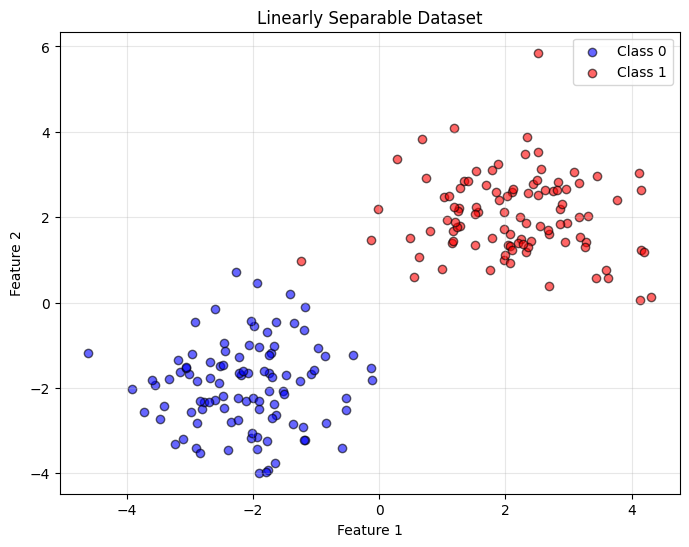

In [7]:
# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(X_linear[y_linear == 0, 0], X_linear[y_linear == 0, 1], 
           c='blue', label='Class 0', alpha=0.6, edgecolors='k')
plt.scatter(X_linear[y_linear == 1, 0], X_linear[y_linear == 1, 1], 
           c='red', label='Class 1', alpha=0.6, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linearly Separable Dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# Train a single perceptron (no hidden layers)
print("=" * 60)
print("Training Perceptron (Single Layer)")
print("=" * 60)

perceptron = MLP(layer_sizes=[2, 1], activations=['sigmoid'])
perceptron.fit(X_linear, y_linear, learning_rate=0.5, epochs=1000)

Training Perceptron (Single Layer)
Epoch 200/1000, Loss: 0.009001
Epoch 400/1000, Loss: 0.006599
Epoch 600/1000, Loss: 0.005484
Epoch 800/1000, Loss: 0.004795
Epoch 1000/1000, Loss: 0.004309

Training completed. Final loss: 0.004309


In [9]:
# Evaluate
train_acc = perceptron.score(X_linear, y_linear)
print(f"\nTraining Accuracy: {train_acc:.4f}")


Training Accuracy: 1.0000


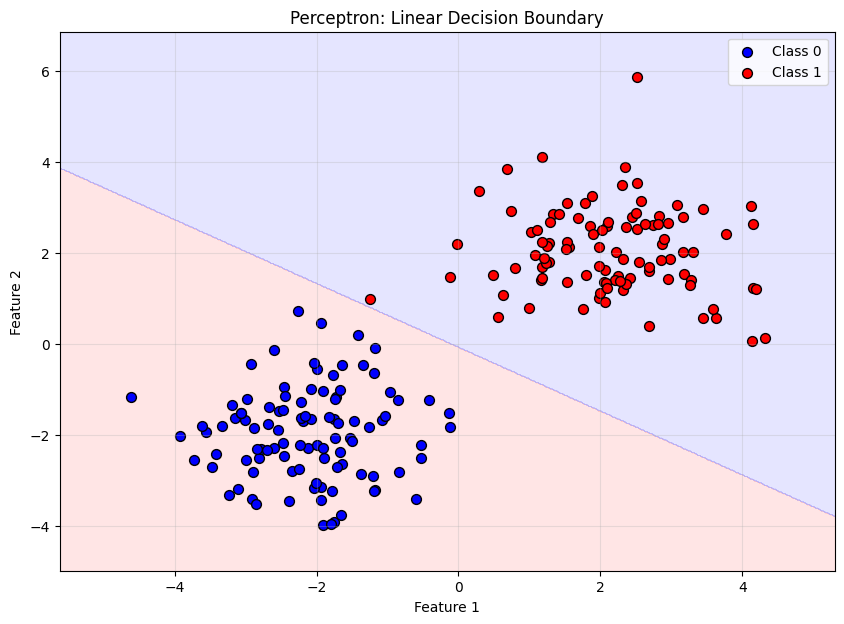

In [10]:
# Plot decision boundary
def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    """Plot decision boundary for 2D classification."""
    h = 0.02  # Step size in mesh
    
    # Create mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='blue', label='Class 0', 
               edgecolors='k', s=50)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='red', label='Class 1', 
               edgecolors='k', s=50)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_decision_boundary(perceptron, X_linear, y_linear, 
                      "Perceptron: Linear Decision Boundary")

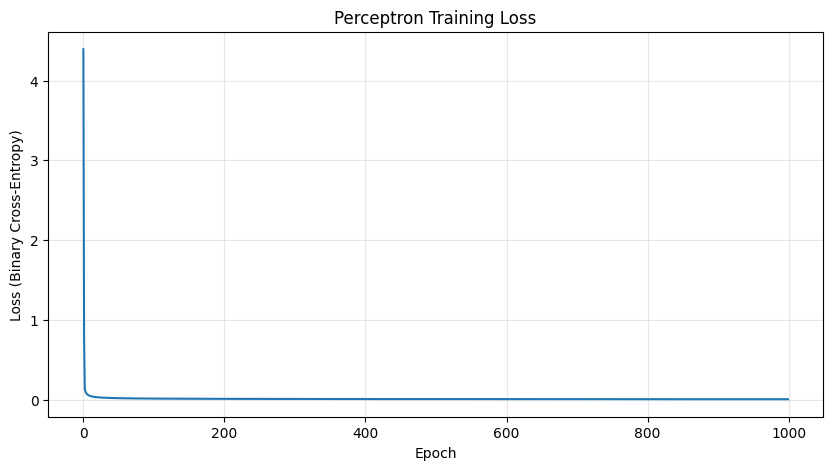

In [11]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(perceptron.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss (Binary Cross-Entropy)')
plt.title('Perceptron Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

### Experiment 2: The XOR Problem

**Why a single perceptron fails:**

XOR is not linearly separable. No single line can separate the classes!

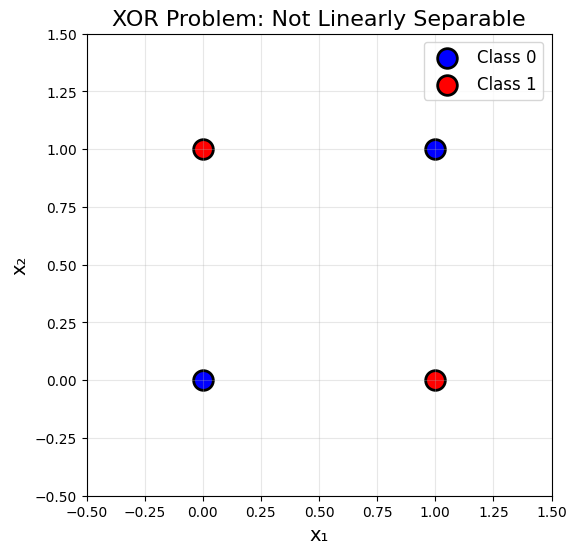

In [12]:
# XOR dataset
X_xor = np.array([[0, 0],
                  [0, 1],
                  [1, 0],
                  [1, 1]])
y_xor = np.array([0, 1, 1, 0])

# Visualize
plt.figure(figsize=(6, 6))
plt.scatter(X_xor[y_xor == 0, 0], X_xor[y_xor == 0, 1], 
           c='blue', label='Class 0', s=200, edgecolors='k', linewidths=2)
plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], 
           c='red', label='Class 1', s=200, edgecolors='k', linewidths=2)
plt.xlabel('x₁', fontsize=14)
plt.ylabel('x₂', fontsize=14)
plt.title('XOR Problem: Not Linearly Separable', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.show()

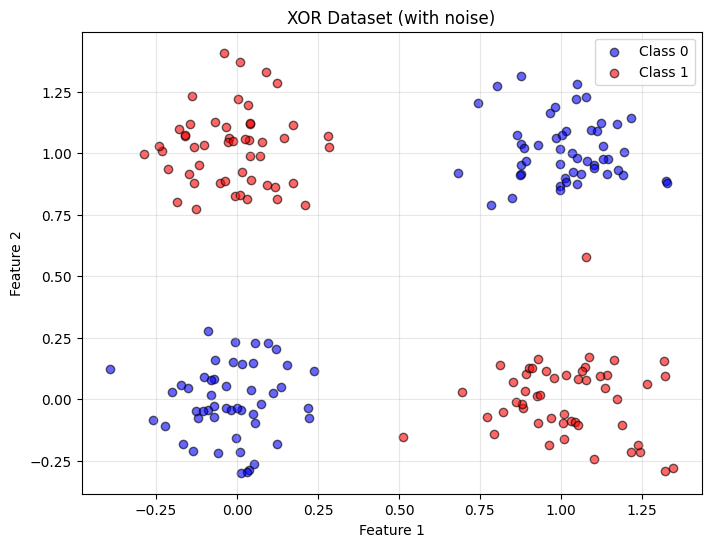

In [13]:
# Create augmented dataset for better visualization
np.random.seed(42)
n_samples_per_class = 50

# Generate XOR pattern with noise
X_xor_full = []
y_xor_full = []

for center, label in [([0, 0], 0), ([0, 1], 1), ([1, 0], 1), ([1, 1], 0)]:
    X_cluster = np.random.randn(n_samples_per_class, 2) * 0.15 + center
    y_cluster = np.full(n_samples_per_class, label)
    X_xor_full.append(X_cluster)
    y_xor_full.append(y_cluster)

X_xor_full = np.vstack(X_xor_full)
y_xor_full = np.concatenate(y_xor_full)

plt.figure(figsize=(8, 6))
plt.scatter(X_xor_full[y_xor_full == 0, 0], X_xor_full[y_xor_full == 0, 1], 
           c='blue', label='Class 0', alpha=0.6, edgecolors='k')
plt.scatter(X_xor_full[y_xor_full == 1, 0], X_xor_full[y_xor_full == 1, 1], 
           c='red', label='Class 1', alpha=0.6, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('XOR Dataset (with noise)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [14]:
# Try perceptron on XOR (will fail!)
print("=" * 60)
print("Attempting Perceptron on XOR (Expected to Fail)")
print("=" * 60)

perceptron_xor = MLP(layer_sizes=[2, 1], activations=['sigmoid'])
perceptron_xor.fit(X_xor_full, y_xor_full, learning_rate=0.5, epochs=1000)

xor_acc = perceptron_xor.score(X_xor_full, y_xor_full)
print(f"\nPerceptron Accuracy on XOR: {xor_acc:.4f}")
print("❌ Perceptron cannot solve XOR!")

Attempting Perceptron on XOR (Expected to Fail)
Epoch 200/1000, Loss: 0.693104
Epoch 400/1000, Loss: 0.693103
Epoch 600/1000, Loss: 0.693103
Epoch 800/1000, Loss: 0.693103
Epoch 1000/1000, Loss: 0.693103

Training completed. Final loss: 0.693103

Perceptron Accuracy on XOR: 0.5050
❌ Perceptron cannot solve XOR!


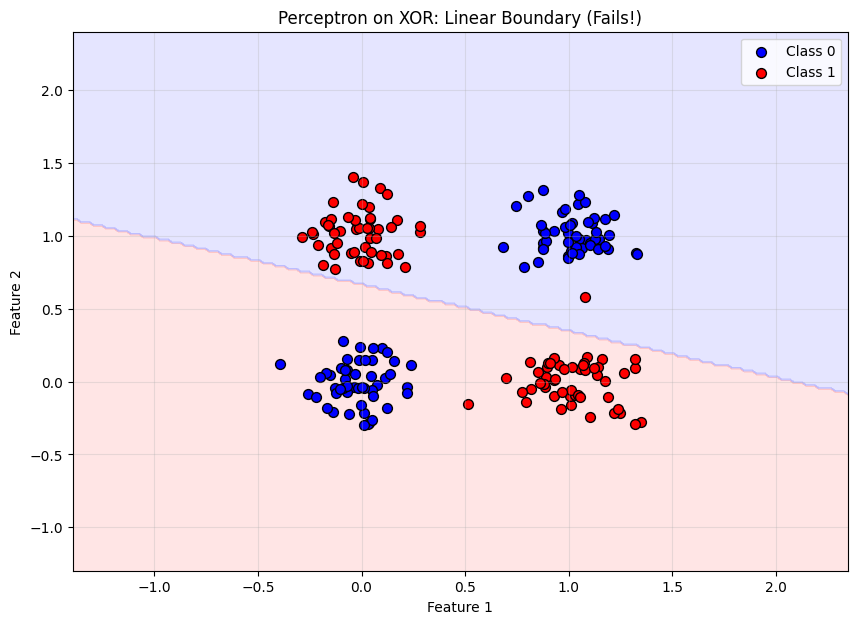

In [15]:
plot_decision_boundary(perceptron_xor, X_xor_full, y_xor_full,
                      "Perceptron on XOR: Linear Boundary (Fails!)")

### Experiment 3: MLP Solves XOR!

With a hidden layer, we can learn non-linear decision boundaries.

In [16]:
# Train MLP with one hidden layer
print("=" * 60)
print("Training MLP on XOR (2-4-1 architecture)")
print("=" * 60)

mlp_xor = MLP(layer_sizes=[2, 4, 1], activations=['sigmoid', 'sigmoid'])
mlp_xor.fit(X_xor_full, y_xor_full, learning_rate=1.0, epochs=2000)

mlp_xor_acc = mlp_xor.score(X_xor_full, y_xor_full)
print(f"\nMLP Accuracy on XOR: {mlp_xor_acc:.4f}")
print("✅ MLP successfully solves XOR!")

Training MLP on XOR (2-4-1 architecture)
Epoch 200/2000, Loss: 0.585792
Epoch 400/2000, Loss: 0.105815
Epoch 600/2000, Loss: 0.046482
Epoch 800/2000, Loss: 0.030568
Epoch 1000/2000, Loss: 0.023267
Epoch 1200/2000, Loss: 0.019044
Epoch 1400/2000, Loss: 0.016267
Epoch 1600/2000, Loss: 0.014286
Epoch 1800/2000, Loss: 0.012791
Epoch 2000/2000, Loss: 0.011616

Training completed. Final loss: 0.011616

MLP Accuracy on XOR: 1.0000
✅ MLP successfully solves XOR!


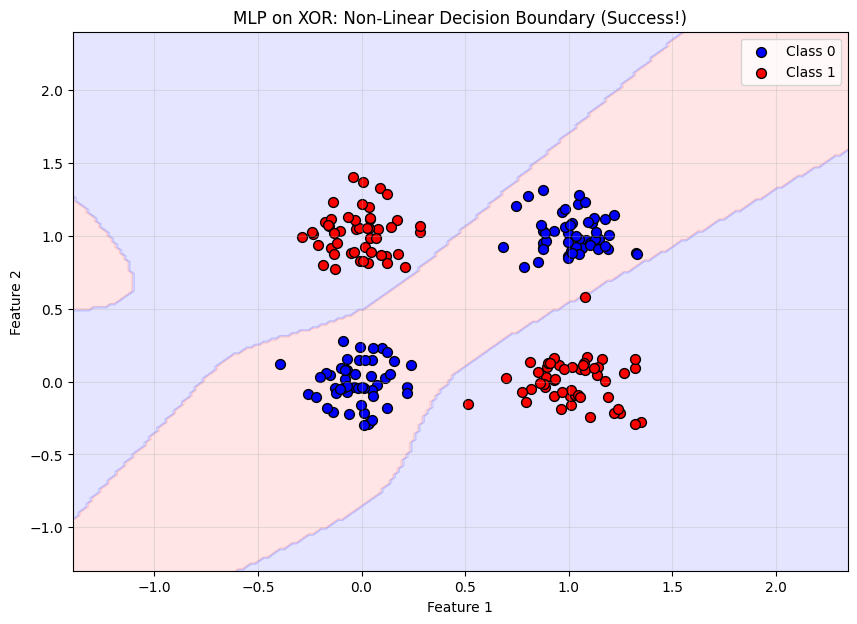

In [17]:
plot_decision_boundary(mlp_xor, X_xor_full, y_xor_full,
                      "MLP on XOR: Non-Linear Decision Boundary (Success!)")

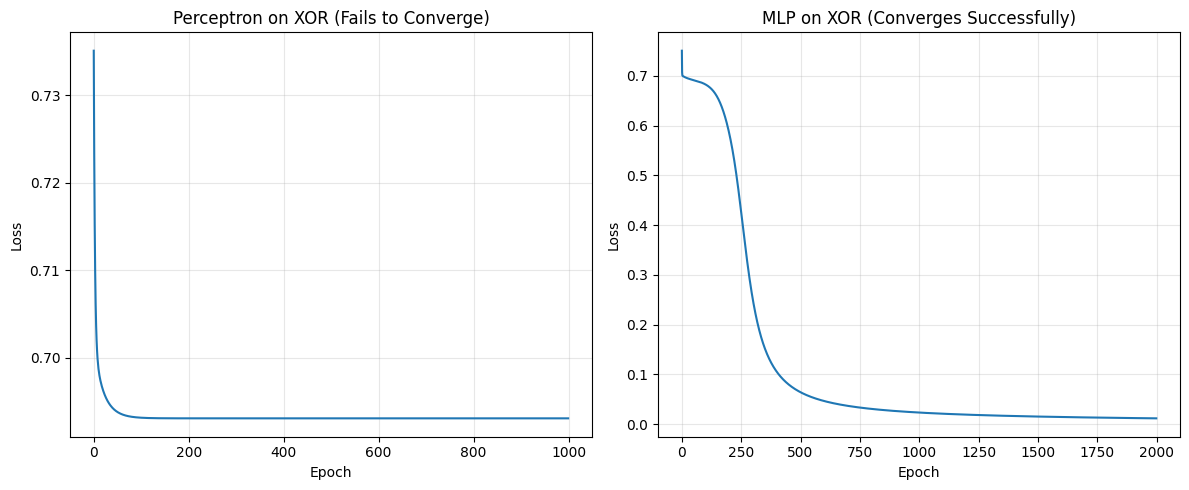

In [18]:
# Compare training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(perceptron_xor.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Perceptron on XOR (Fails to Converge)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(mlp_xor.losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP on XOR (Converges Successfully)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Experiment 4: Complex Non-Linear Classification

Let's try a more complex dataset: circular decision boundary.

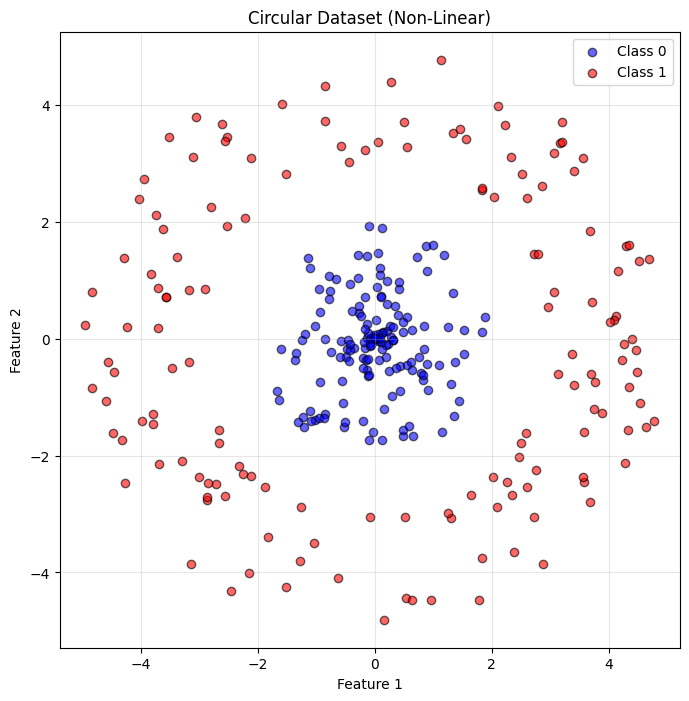

In [19]:
# Generate circular dataset
np.random.seed(42)
n_samples = 300

# Inner circle (class 0)
r_inner = np.random.uniform(0, 2, n_samples // 2)
theta_inner = np.random.uniform(0, 2 * np.pi, n_samples // 2)
X_inner = np.column_stack([r_inner * np.cos(theta_inner), 
                          r_inner * np.sin(theta_inner)])
y_inner = np.zeros(n_samples // 2)

# Outer ring (class 1)
r_outer = np.random.uniform(3, 5, n_samples // 2)
theta_outer = np.random.uniform(0, 2 * np.pi, n_samples // 2)
X_outer = np.column_stack([r_outer * np.cos(theta_outer), 
                          r_outer * np.sin(theta_outer)])
y_outer = np.ones(n_samples // 2)

# Combine
X_circle = np.vstack([X_inner, X_outer])
y_circle = np.concatenate([y_inner, y_outer])

# Shuffle
shuffle_idx = np.random.permutation(n_samples)
X_circle = X_circle[shuffle_idx]
y_circle = y_circle[shuffle_idx]

# Visualize
plt.figure(figsize=(8, 8))
plt.scatter(X_circle[y_circle == 0, 0], X_circle[y_circle == 0, 1], 
           c='blue', label='Class 0', alpha=0.6, edgecolors='k')
plt.scatter(X_circle[y_circle == 1, 0], X_circle[y_circle == 1, 1], 
           c='red', label='Class 1', alpha=0.6, edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Circular Dataset (Non-Linear)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

In [20]:
# Train MLP on circular data
print("=" * 60)
print("Training MLP on Circular Dataset (2-8-1 architecture)")
print("=" * 60)

mlp_circle = MLP(layer_sizes=[2, 8, 1], activations=['sigmoid', 'sigmoid'])
mlp_circle.fit(X_circle, y_circle, learning_rate=0.5, epochs=2000)

circle_acc = mlp_circle.score(X_circle, y_circle)
print(f"\nMLP Accuracy on Circular Data: {circle_acc:.4f}")

Training MLP on Circular Dataset (2-8-1 architecture)
Epoch 200/2000, Loss: 0.362555
Epoch 400/2000, Loss: 0.127488
Epoch 600/2000, Loss: 0.071180
Epoch 800/2000, Loss: 0.048769
Epoch 1000/2000, Loss: 0.036620
Epoch 1200/2000, Loss: 0.028967
Epoch 1400/2000, Loss: 0.023749
Epoch 1600/2000, Loss: 0.020021
Epoch 1800/2000, Loss: 0.017264
Epoch 2000/2000, Loss: 0.015159

Training completed. Final loss: 0.015159

MLP Accuracy on Circular Data: 1.0000


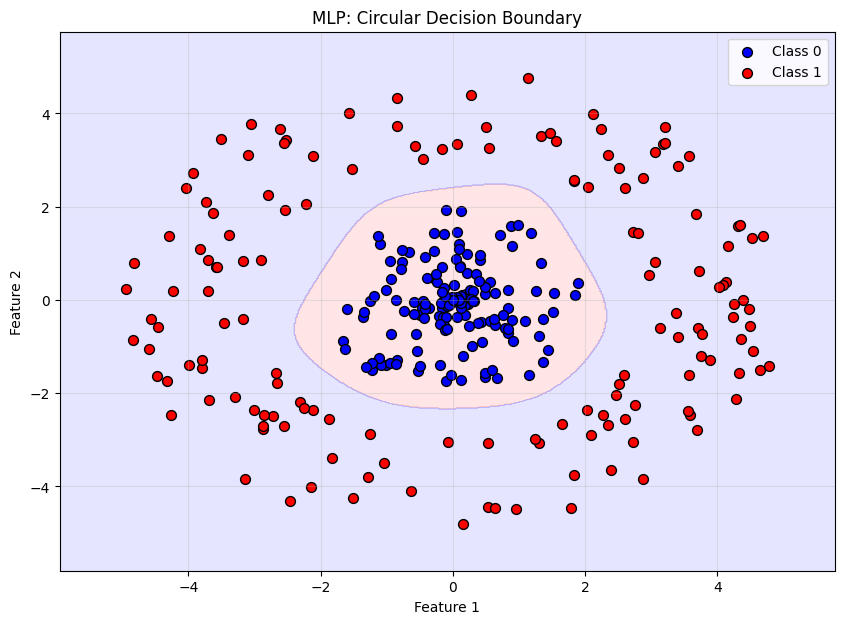

In [21]:
plot_decision_boundary(mlp_circle, X_circle, y_circle,
                      "MLP: Circular Decision Boundary")

<a id='visualization'></a>
## 6. Part 5: Deeper Analysis

---

### Visualize Learned Features

Let's look at what the hidden layer learns.

In [22]:
# Get hidden layer activations for XOR problem
X_test = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_test = np.array([0, 1, 1, 0])

# Forward pass to hidden layer
X_T = X_test.T
hidden_activations = mlp_xor.layers[0].forward(X_T).T

print("Input -> Hidden Layer Transformation:")
print("\nInput (XOR):")
print(X_test)
print("\nHidden Layer Activations (4 neurons):")
print(hidden_activations)
print("\nTrue Labels:")
print(y_test)

Input -> Hidden Layer Transformation:

Input (XOR):
[[0 0]
 [0 1]
 [1 0]
 [1 1]]

Hidden Layer Activations (4 neurons):
[[6.07422843e-02 2.89573711e-01 2.47241175e-01 8.89602093e-01]
 [9.68144872e-01 7.28123886e-01 9.67161467e-01 9.99912744e-01]
 [2.82434985e-05 3.04122655e-01 9.77403754e-01 2.21507417e-02]
 [1.30996205e-02 7.41702788e-01 9.99742249e-01 9.69892576e-01]]

True Labels:
[0 1 1 0]


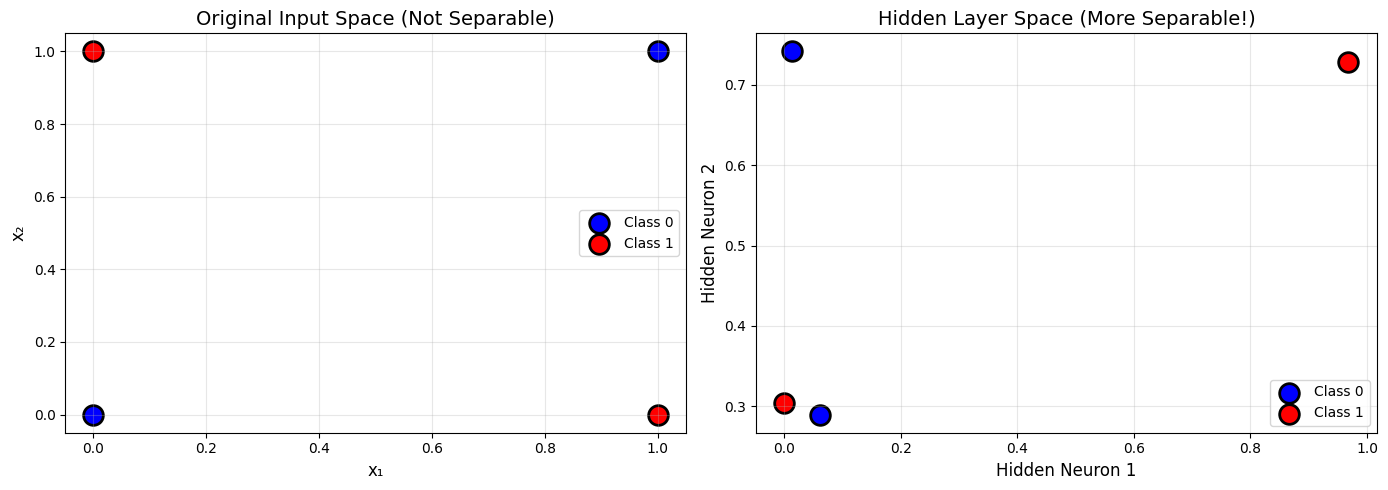


💡 The hidden layer transforms the data into a space where classes are more separable!


In [23]:
# Visualize feature transformation
fig = plt.figure(figsize=(14, 5))

# Original space
ax1 = fig.add_subplot(121)
ax1.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], 
           c='blue', s=200, edgecolors='k', linewidths=2, label='Class 0')
ax1.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], 
           c='red', s=200, edgecolors='k', linewidths=2, label='Class 1')
ax1.set_xlabel('x₁', fontsize=12)
ax1.set_ylabel('x₂', fontsize=12)
ax1.set_title('Original Input Space (Not Separable)', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Hidden space (first 2 dimensions)
ax2 = fig.add_subplot(122)
ax2.scatter(hidden_activations[y_test == 0, 0], hidden_activations[y_test == 0, 1], 
           c='blue', s=200, edgecolors='k', linewidths=2, label='Class 0')
ax2.scatter(hidden_activations[y_test == 1, 0], hidden_activations[y_test == 1, 1], 
           c='red', s=200, edgecolors='k', linewidths=2, label='Class 1')
ax2.set_xlabel('Hidden Neuron 1', fontsize=12)
ax2.set_ylabel('Hidden Neuron 2', fontsize=12)
ax2.set_title('Hidden Layer Space (More Separable!)', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 The hidden layer transforms the data into a space where classes are more separable!")

### Effect of Hidden Layer Size

In [24]:
# Compare different hidden layer sizes on XOR
hidden_sizes = [2, 4, 8, 16]
results = []

print("Testing different hidden layer sizes on XOR...")
print("=" * 60)

for h in hidden_sizes:
    np.random.seed(42)
    mlp = MLP(layer_sizes=[2, h, 1], activations=['sigmoid', 'sigmoid'])
    mlp.fit(X_xor_full, y_xor_full, learning_rate=1.0, epochs=2000, verbose=False)
    acc = mlp.score(X_xor_full, y_xor_full)
    results.append((h, acc, mlp.losses[-1]))
    print(f"Hidden size: {h:2d} | Accuracy: {acc:.4f} | Final Loss: {mlp.losses[-1]:.6f}")

print("=" * 60)

Testing different hidden layer sizes on XOR...
Hidden size:  2 | Accuracy: 0.9950 | Final Loss: 0.026000
Hidden size:  4 | Accuracy: 1.0000 | Final Loss: 0.010866
Hidden size:  8 | Accuracy: 1.0000 | Final Loss: 0.009542
Hidden size: 16 | Accuracy: 1.0000 | Final Loss: 0.011036


<a id='summary'></a>
## 7. Summary

---

### What We've Learned

#### 1. **The Perceptron**
   - Single neuron with activation function
   - Can solve linearly separable problems
   - Fails on XOR (not linearly separable)

#### 2. **Multi-Layer Perceptron**
   - Stacking layers enables non-linear decision boundaries
   - Hidden layers learn useful feature representations
   - Can solve complex classification problems

#### 3. **Mathematical Foundations**
   
   **Forward Propagation:**
   $$z^{[\ell]} = W^{[\ell]} a^{[\ell-1]} + b^{[\ell]}$$
   $$a^{[\ell]} = \sigma(z^{[\ell]})$$
   
   **Backpropagation:**
   $$\delta^{[\ell]} = [(W^{[\ell+1]})^\top \delta^{[\ell+1]}] \odot \sigma'(z^{[\ell]})$$
   $$\frac{\partial L}{\partial W^{[\ell]}} = \delta^{[\ell]} (a^{[\ell-1]})^\top$$
   $$\frac{\partial L}{\partial b^{[\ell]}} = \delta^{[\ell]}$$

#### 4. **Key Insights**
   - **Activation functions** introduce non-linearity
   - **Hidden layers** transform data into more separable representations
   - **Backpropagation** efficiently computes all gradients via chain rule
   - **Deeper/wider networks** can learn more complex functions

#### 5. **Practical Implementation**
   - Vectorized operations for efficiency
   - Careful gradient derivations
   - Xavier initialization for stable training
   - Clean, modular code design

---

### Next Steps

- **Regularization:** Add dropout, L2 penalty to prevent overfitting
- **Advanced Optimizers:** Momentum, Adam, RMSprop
- **Batch Normalization:** Stabilize and accelerate training
- **Different Activations:** ReLU, Leaky ReLU, ELU
- **Deeper Networks:** More layers for more complex tasks
- **Convolutional Networks:** For image data
- **Recurrent Networks:** For sequential data

---

## 🎉 Congratulations!

You've built a complete neural network from scratch, understanding every mathematical detail from first principles!